# **Importing Libraries**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tqdm import tqdm

# **The Ant Class**

In [14]:
class Ant:
  def __init__(self, x, y, grid_size):
    self.x = x
    self.y = y
    self.carrying= None
    self.grid_size = grid_size

  def move(self, new_x, new_y):
    self.x = new_x
    self.y = new_y

  def pick_up(self, object_id):
    self.carrying = object_id

  def drop(self):
    object_id= self.carrying
    self.carrying = None
    return object_id

# **The Grid Class**

In [15]:
class Grid:
  def __init__(self, size):
    self.size = size
    self.cells = [[None for _ in range(size)] for _ in range(size)]

  def get_neighbors(self, x, y,radius=3):
    neighbors = []
    for i in range(-radius, radius + 1):
      for j in range(-radius, radius + 1):
        nx, ny = (x + i) % self.size , (y + j) % self.size
        if (nx, ny) != (x, y):
          neighbors.append((nx, ny))

    return neighbors

  def get_local_density(self, x, y, radius=3):
    neighbors = self.get_neighbors(x, y, radius)
    density = sum(1 for nx, ny in neighbors if self.cells[nx][ny] is not None)
    return density


# **hACA Algorithm**

In [94]:
class hACA:
  def __init__(self, num_ants, grid_size, num_objects, object_data):
    self.num_ants = num_ants
    self.grid_size = grid_size
    self.num_objects = num_objects
    self.object_data = object_data
    self.grid = Grid(grid_size)
    self.ants = []
    self.object_ids = list(range(num_objects))


    # intialize ants and objects in the grid
    for _ in range(num_ants):
      x, y = np.random.randint(0, grid_size,2)
      self.ants.append(Ant(x, y, grid_size))

    np.random.shuffle(self.object_ids)
    for i, obj_id in enumerate(self.object_ids):
      x, y = np.random.randint(0, grid_size,2)
      self.grid.cells[x][y] = obj_id


  def ga_move(self, ant):
    # Encode current position as binary
    current_x, current_y = ant.x, ant.y
    Lbits = int(np.ceil(np.log2(self.grid_size)))
    current_x_bits = format(current_x, '0{}b'.format(Lbits))
    current_y_bits = format(current_y, '0{}b'.format(Lbits))
    current_bits = current_x_bits + current_y_bits

    # Generate a random position and encode it as binary
    random_x, random_y = np.random.randint(0, self.grid_size, 2)
    random_x_bits = format(random_x, '0{}b'.format(Lbits))
    random_y_bits = format(random_y, '0{}b'.format(Lbits))
    random_bits = random_x_bits + random_y_bits

    # Perform crossover
    crossover_point = np.random.randint(1, len(current_bits))
    child_bits = current_bits[:crossover_point] + random_bits[crossover_point:]

    # Perform mutation
    mutation_prob = 0.02
    child_bits_list = list(child_bits)
    for i in range(len(child_bits_list)):
        if np.random.rand() < mutation_prob:
            child_bits_list[i] = '1' if child_bits_list[i] == '0' else '0'
    child_bits = ''.join(child_bits_list)

    # Decode child bits to get new position
    new_x_bits = child_bits[:Lbits]
    new_y_bits = child_bits[Lbits:]
    new_x = int(new_x_bits, 2)
    new_y = int(new_y_bits, 2)

    # Ensure new position is within grid bounds
    new_x = new_x % self.grid_size
    new_y = new_y % self.grid_size

    return new_x, new_y


  def run(self, num_iterations,k1=3,k2=0.3):
    for _ in tqdm(range(num_iterations),desc="iteratiion no."):
      for ant in self.ants:
        # GA Move
        new_x, new_y = self.ga_move(ant)
        ant.move(new_x, new_y)

        # Get the local density of the new location
        local_density = self.grid.get_local_density(new_x, new_y)

        # Decide whether to pick up or drop an object based on local density
        if ant.carrying is None:
          if self.grid.cells[new_x][new_y] is not None:
            object_id= self.grid.cells[new_x][new_y]
            # Pick that object with P_pick
            pick_prob = (k1/(k1+local_density))**2
            if np.random.rand() < pick_prob:
              ant.pick_up(object_id)
              self.grid.cells[new_x][new_y] = None

        else:
          drop_prob = (local_density/(k2+local_density))**2
          if np.random.rand() < drop_prob:
            self.grid.cells[new_x][new_y] = ant.drop()

  def count_clusters(self):
    cluster_labels = np.zeros((self.grid_size, self.grid_size), dtype=int)
    cluster_count = 0

    for i in range(self.grid_size):
        for j in range(self.grid_size):
            if self.grid.cells[i][j] is not None and cluster_labels[i, j] == 0:
                cluster_count += 1
                self._flood_fill(i, j, cluster_count, cluster_labels)

    return cluster_count

  def _flood_fill(self, i, j, label, cluster_labels):
    stack = [(i, j)]
    while stack:
        x, y = stack.pop()
        if cluster_labels[x, y] == 0:
            cluster_labels[x, y] = label
            for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size and self.grid.cells[nx][ny] is not None:
                    if self.grid.cells[nx][ny] == self.grid.cells[x][y]:
                        stack.append((nx, ny))


  def visualize_grid(self, show_ants=True, save_path=None):
    """
    Visualize the grid with objects and optionally ants.

    Parameters:
    -----------
    show_ants : bool
        Whether to show the ants on the grid
    save_path : str or None
        If provided, save the visualization to this path
    """
    # Create a figure and axis
    fig, ax = plt.figure(figsize=(10, 10)), plt.gca()

    # Draw grid lines
    for i in range(self.grid_size + 1):
        ax.axhline(i, color='gray', linestyle='-', alpha=0.3)
        ax.axvline(i, color='gray', linestyle='-', alpha=0.3)

    # Draw objects
    for i in range(self.grid_size):
        for j in range(self.grid_size):
            if self.grid.cells[i][j] is not None:
                object_id = self.grid.cells[i][j]
                # Get the feature vector for this object
                feature_vector = self.object_data[object_id]

                # Map feature vector to a color - here we'll use the first 3 features
                # as RGB values, or use a hash function if fewer features
                if len(feature_vector) >= 3:
                    # Normalize to [0,1] for RGB
                    rgb = feature_vector[:3]
                    rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb) + 1e-10)
                else:
                    # Hash the object ID to get a consistent color
                    color_idx = object_id % 20  # Use 20 different colors
                    rgb = plt.cm.tab20(color_idx)[:3]

                # Draw a colored circle for each object
                circle = plt.Circle((j + 0.5, i + 0.5), 0.4, color=rgb, alpha=0.7)
                ax.add_patch(circle)

    # Draw ants if requested
    if show_ants:
        for ant in self.ants:
            if ant.carrying is not None:
                # Ant carrying an object - draw as a black X
                ax.plot(ant.y + 0.5, ant.x + 0.5, 'kx', markersize=10, markeredgewidth=2)
            else:
                # Ant not carrying an object - draw as a black dot
                ax.plot(ant.y + 0.5, ant.x + 0.5, 'ko', markersize=8)

    # Set limits and labels
    ax.set_xlim(0, self.grid_size)
    ax.set_ylim(0, self.grid_size)
    ax.set_xticks(np.arange(0.5, self.grid_size, 1))
    ax.set_yticks(np.arange(0.5, self.grid_size, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert y-axis to match grid coordinates

    plt.title('hACA Grid Visualization')

    # Save if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)

    plt.show()
    return fig, ax

  def visualize_clusters(self):
    """Visualize identified clusters with distinct colors"""
    # First identify clusters using flood fill
    cluster_labels = np.zeros((self.grid_size, self.grid_size), dtype=int)
    cluster_count = 0

    for i in range(self.grid_size):
        for j in range(self.grid_size):
            if self.grid.cells[i][j] is not None and cluster_labels[i, j] == 0:
                cluster_count += 1
                self._flood_fill(i, j, cluster_count, cluster_labels)

    # Then visualize with cluster-specific colors
    fig, ax = plt.figure(figsize=(10, 10)), plt.gca()

    # Draw grid lines
    for i in range(self.grid_size + 1):
        ax.axhline(i, color='gray', linestyle='-', alpha=0.3)
        ax.axvline(i, color='gray', linestyle='-', alpha=0.3)

    # Draw objects colored by cluster
    cmap = plt.cm.get_cmap('tab20', cluster_count)

    for i in range(self.grid_size):
        for j in range(self.grid_size):
            if self.grid.cells[i][j] is not None:
                cluster_id = cluster_labels[i, j]
                circle = plt.Circle((j + 0.5, i + 0.5), 0.4,
                                   color=cmap(cluster_id-1),
                                   alpha=0.7)
                ax.add_patch(circle)

    plt.title(f'hACA Clusters (Total: {cluster_count})')
    ax.set_xlim(0, self.grid_size)
    ax.set_ylim(0, self.grid_size)
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # Add a colorbar legend
    from matplotlib.colorbar import ColorbarBase
    from matplotlib.colors import Normalize

    norm = Normalize(vmin=1, vmax=cluster_count)
    cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])  # [left, bottom, width, height]
    ColorbarBase(cax, cmap=cmap, norm=norm, label='Cluster ID')

    plt.show()
    return cluster_count


# **Run The Algorithm and visualize the result**

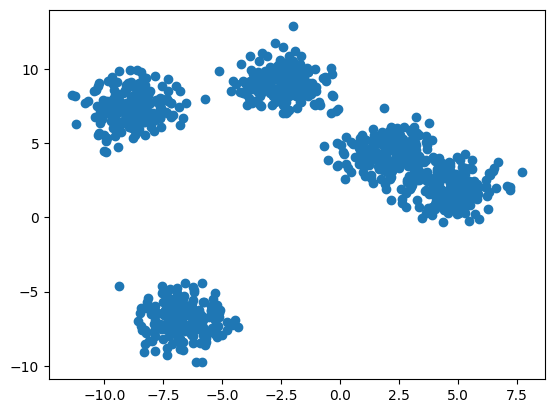

In [95]:
# Generate a sample dataset
object_data, _ = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42)
plt.scatter(object_data[:, 0], object_data[:, 1])
plt.show()

iteratiion no.: 100%|██████████| 10000/10000 [06:02<00:00, 27.59it/s]


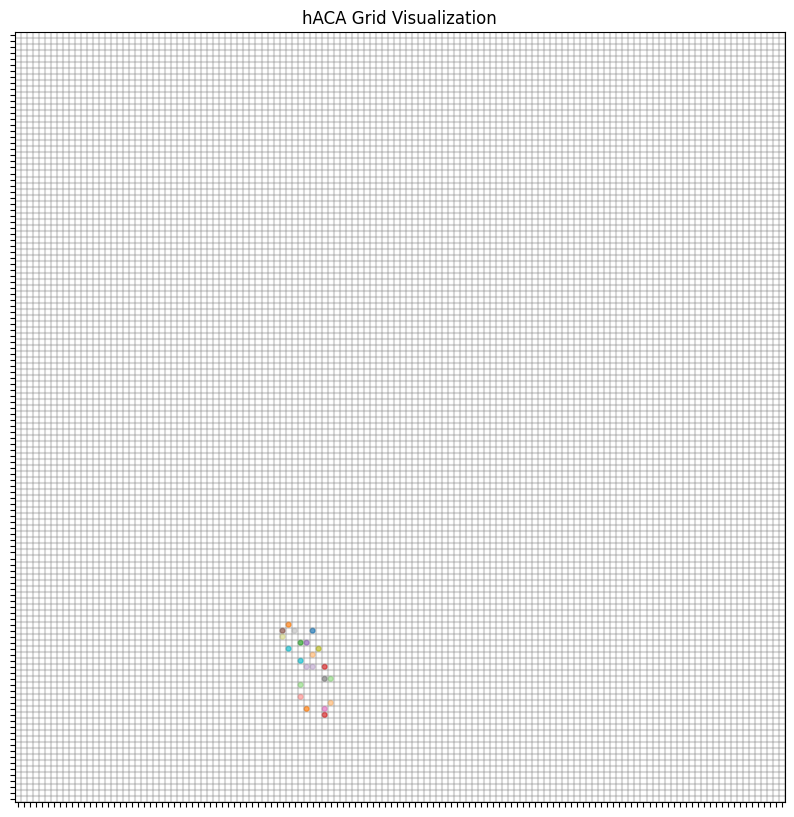

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'hACA Grid Visualization'}>)

In [96]:
num_ants = 500
grid_size = 128
num_objects = len(object_data)
haca = hACA(num_ants, grid_size, num_objects, object_data)
haca.run(num_iterations=10000)
haca.visualize_grid(show_ants=False)

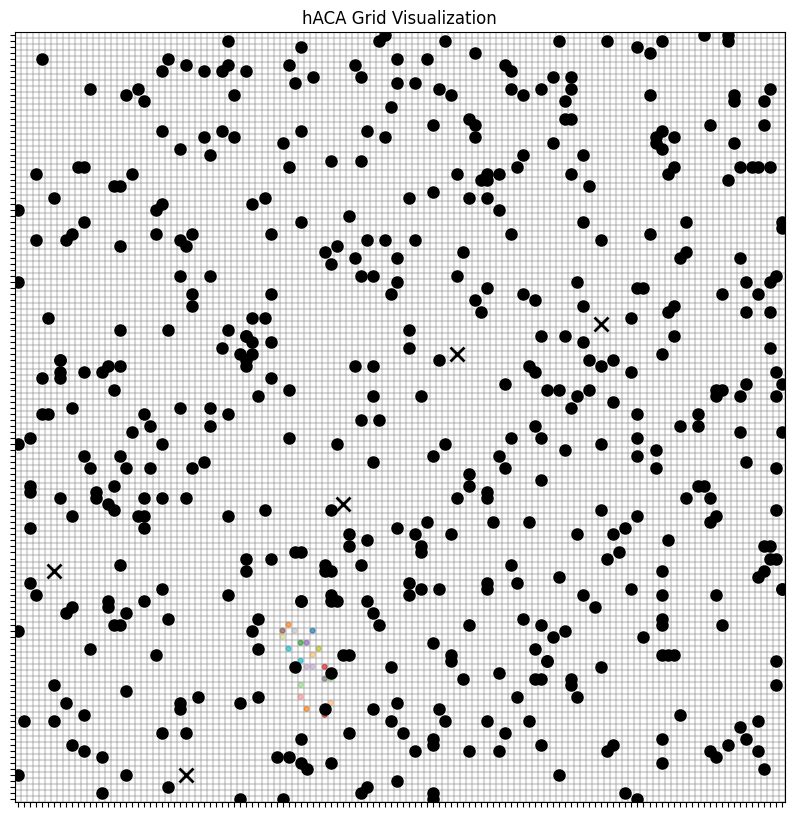

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'hACA Grid Visualization'}>)

In [98]:
haca.visualize_grid(show_ants=True)

<ipython-input-94-71f2443bf1ff>:204: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', cluster_count)


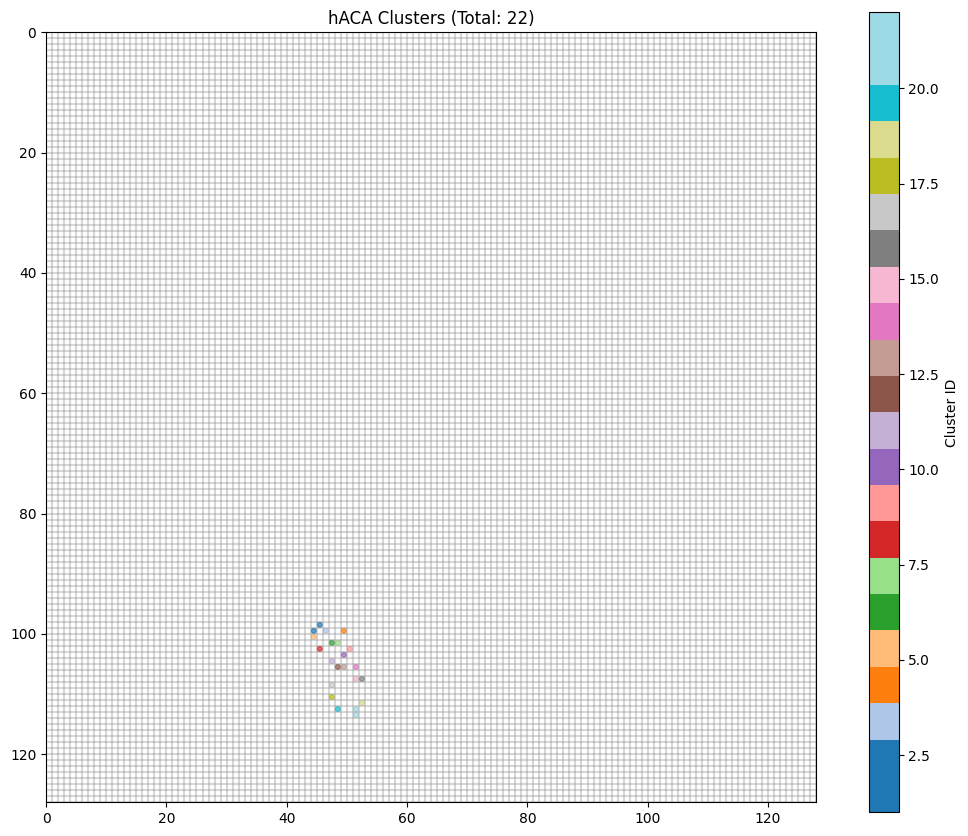

22

In [97]:
haca.visualize_clusters()